# Un arbre de décision en réseaux de neurones

L'idée est de convertir sous la forme d'un réseaux de neurones un arbre de décision puis de continuer l'apprentissage de façon à obtenir un assemblage de régression logistique plutôt que de décision binaire. 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline
from jyquickhelper import RenderJsDot
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

## Un exemple sur Iris

La méthode ne marche que sur un problème de classification binaire.

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data[:, :2], data.target
y = y % 2

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [5]:
from sklearn.tree import DecisionTreeClassifier
dec = DecisionTreeClassifier(max_depth=2, random_state=11)
dec.fit(X_train, y_train)
dec.score(X_test, y_test)

0.6052631578947368

In [6]:
from sklearn.tree import export_graphviz
dot = export_graphviz(dec, filled=True)
dot = dot.replace("shape=box, ", "shape=box, fontsize=10, ")
RenderJsDot(dot)
print(dot)

digraph Tree {
node [shape=box, fontsize=10, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="X[1] <= 2.95\ngini = 0.454\nsamples = 112\nvalue = [73, 39]", fillcolor="#f3c4a3"] ;
1 [label="X[0] <= 7.05\ngini = 0.429\nsamples = 45\nvalue = [14, 31]", fillcolor="#92c9f1"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.402\nsamples = 43\nvalue = [12, 31]", fillcolor="#86c3ef"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 2\nvalue = [2, 0]", fillcolor="#e58139"] ;
1 -> 3 ;
4 [label="X[1] <= 3.25\ngini = 0.21\nsamples = 67\nvalue = [59, 8]", fillcolor="#e99254"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.375\nsamples = 32\nvalue = [24, 8]", fillcolor="#eeab7b"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 35\nvalue = [35, 0]", fillcolor="#e58139"] ;
4 -> 6 ;
}


L'arbre de décision est petit donc visuellement réduit et il est perfectible aussi.

## Même exemple en réseau de neurones

Chaque noeud de l'arbre de décision est converti en deux neurones :
* un qui le relie à l'entrée et qui évalue la décision, il produit la valeur $o_1$
* un autre qui associe le résultat du premier noeud avec celui le précède dans la structure de l'arbre de décision, il produit la valeur $o_2$
La décision finale est quelque chose comme $sigmoid(o_1 + o_2 - 1)$. Un neurone agrège le résultat de toutes les feuilles.



In [7]:
from mlstatpy.ml.neural_tree import NeuralTreeNet
net = NeuralTreeNet.create_from_tree(dec)
RenderJsDot(net.to_dot())

On considère une entrée en particulier.

In [8]:
n = 60
dec.predict_proba(X[n: n+1])

array([[0.27906977, 0.72093023]])

Les sorties du réseau de neurones :

In [9]:
net.predict(X[n: n+1])[:, -2:]

array([[0.12536069, 0.87463931]])

Et on trace les valeurs intermédiaires.

In [10]:
RenderJsDot(net.to_dot(X=X[n]))

On poursuit la comparaison :

In [11]:
dec.predict_proba(X_test)[:5]

array([[0.75      , 0.25      ],
       [0.75      , 0.25      ],
       [0.27906977, 0.72093023],
       [1.        , 0.        ],
       [0.27906977, 0.72093023]])

In [12]:
net.predict(X_test)[:5, -2:]

array([[0.79156817, 0.20843183],
       [0.73646978, 0.26353022],
       [0.29946111, 0.70053889],
       [0.94070094, 0.05929906],
       [0.24924737, 0.75075263]])

In [13]:
dec.predict_proba(X_test)[-5:]

array([[1.  , 0.  ],
       [0.75, 0.25],
       [1.  , 0.  ],
       [0.75, 0.25],
       [0.75, 0.25]])

In [14]:
net.predict(X_test)[-5:, -2:]

array([[0.93247891, 0.06752109],
       [0.86338585, 0.13661415],
       [0.98219036, 0.01780964],
       [0.98352807, 0.01647193],
       [0.73646978, 0.26353022]])

In [15]:
numpy.argmax(net.predict(X_test)[-5:, -2:], axis=1)

array([0, 0, 0, 0, 0], dtype=int64)

On compare visuellement les deux frontières de classification.

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


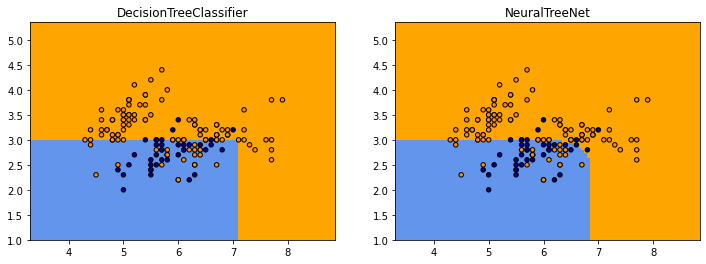

In [16]:
def plot_grid(X, y, fct, title, ax=None):
    
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])    

    h = .05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = fct(numpy.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(X, y, dec.predict, dec.__class__.__name__, ax=ax[0])
plot_grid(X, y,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          net.__class__.__name__, ax=ax[1])

Le code qui produit les prédictions du réseau de neurones est assez long à exécuter mais il produit à peu près les mêmes frontières excepté qu'elles sont plus arrondies.

## Intermède de simples neurones de régression

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de régression. Le neurone n'est pas converti, il est appris.

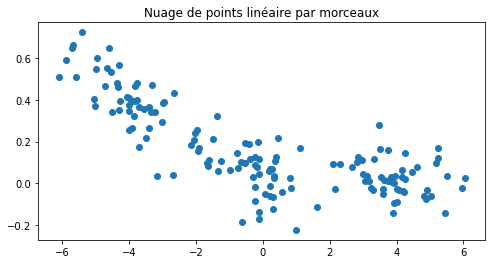

In [17]:
regX = numpy.empty((150, 1), dtype=numpy.float64)
regX[:50, 0] = numpy.random.randn(50) - 4
regX[50:100, 0] = numpy.random.randn(50)
regX[100:, 0] = numpy.random.randn(50) + 4
noise = numpy.random.randn(regX.shape[0]) / 10
regY = regX[:, 0] * -0.5 * 0.2 + noise
regY[regX[:, 0] > 0.3] = noise[regX[:, 0] > 0.3]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.set_title("Nuage de points linéaire par morceaux");

On cale une régression avec *scikit-learn*.

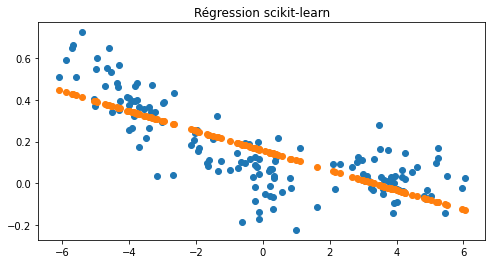

In [18]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(regX, regY)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX))
ax.set_title("Régression scikit-learn");

Et maintenant un neurone avec une fonction d'activation "identity".

In [19]:
from mlstatpy.ml.neural_tree import NeuralTreeNode
neu = NeuralTreeNode(1, activation="identity")
neu

NeuralTreeNode(weights=array([0.24515488]), bias=0.10874563175403863, activation='identity')

In [20]:
neu.fit(regX, regY, verbose=True, max_iter=20)

0/20: loss: 150.8 lr=0.002 max(coef): 0.25 l1=0/0.35 l2=0/0.072
1/20: loss: 2.872 lr=0.000163 max(coef): 0.19 l1=1.8/0.25 l2=2.1/0.039
2/20: loss: 2.774 lr=0.000115 max(coef): 0.19 l1=0.3/0.25 l2=0.066/0.041
3/20: loss: 2.621 lr=9.42e-05 max(coef): 0.18 l1=0.16/0.23 l2=0.015/0.036
4/20: loss: 2.658 lr=8.16e-05 max(coef): 0.17 l1=1.9/0.23 l2=2.5/0.033
5/20: loss: 2.58 lr=7.3e-05 max(coef): 0.17 l1=0.44/0.21 l2=0.13/0.03
6/20: loss: 2.611 lr=6.66e-05 max(coef): 0.16 l1=0.11/0.2 l2=0.0096/0.028
7/20: loss: 2.542 lr=6.17e-05 max(coef): 0.16 l1=0.17/0.21 l2=0.018/0.029
8/20: loss: 2.52 lr=5.77e-05 max(coef): 0.16 l1=0.41/0.21 l2=0.12/0.029
9/20: loss: 2.516 lr=5.44e-05 max(coef): 0.16 l1=0.1/0.21 l2=0.006/0.028
10/20: loss: 2.516 lr=5.16e-05 max(coef): 0.16 l1=0.24/0.21 l2=0.039/0.028
11/20: loss: 2.514 lr=4.92e-05 max(coef): 0.16 l1=0.48/0.21 l2=0.16/0.028
12/20: loss: 2.526 lr=4.71e-05 max(coef): 0.16 l1=0.027/0.2 l2=0.00041/0.027
13/20: loss: 2.52 lr=4.53e-05 max(coef): 0.16 l1=0.32/0.21

NeuralTreeNode(weights=array([-0.04747787]), bias=0.15725388033694113, activation='identity')

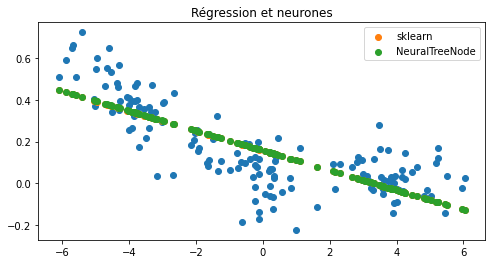

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
ax.scatter(regX[:, 0], neu.predict(regX), label="NeuralTreeNode")
ax.legend()
ax.set_title("Régression et neurones");

Ca marche. Et avec d'autres fonctions d'activation...

In [22]:
neus = {'identity': neu}
for act in tqdm(['relu', 'leakyrelu', 'sigmoid']):
    nact = NeuralTreeNode(1, activation=act)
    nact.fit(regX, regY)
    neus[act] = nact

100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


In [23]:
neus['relu'], neus['leakyrelu']

(NeuralTreeNode(weights=array([-0.56717432]), bias=-2.0796272519664116, activation='relu'),
 NeuralTreeNode(weights=array([-0.11951102]), bias=-0.08125009545262747, activation='leakyrelu'))

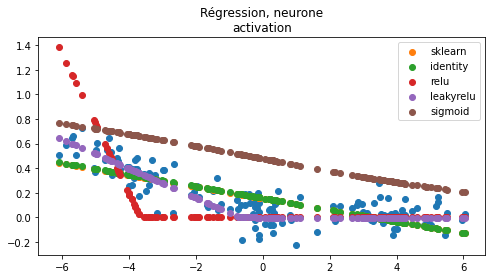

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
for k, v in neus.items():
    ax.scatter(regX[:, 0], v.predict(regX), label=k)
ax.legend()
ax.set_title("Régression, neurone\nactivation");

Rien de surprenant. La fonction sigmoïde prend ses valeurs entre 0 et 1. La fonction *relu* est parfois nulle sur une demi-droite, dès que la fonction est nulle sur l'ensemble du nuage de points, le gradient est nul partout (voir [Rectifier (neural networks)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))). La fonction leaky relu est définie comme suit :

$$f(x) = \left\{\begin{array}{l} x \, si \, x > 0 \\ \frac{x}{100} \, sinon \end{array}\right.$$

Le gradient n'est pas nul sur la partie la plus plate.

## Intermède de simples neurones de classification

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de classification. Le neurone n'est pas converti mais appris.

In [25]:
from sklearn.linear_model import LogisticRegression


clsX = numpy.empty((100, 2), dtype=numpy.float64)
clsX[:50] = numpy.random.randn(50, 2)
clsX[50:] = numpy.random.randn(50, 2) + 2
clsy = numpy.zeros(100, dtype=numpy.int64)
clsy[50:] = 1

logr = LogisticRegression()
logr.fit(clsX, clsy)
pred1 = logr.predict(clsX)

In [26]:
def line_cls(x0, x1, coef, bias):
    y0 = -(coef[0,0] * x0 + bias) / coef[0,1]
    y1 = -(coef[0,0] * x1 + bias) / coef[0,1]
    return x0, y0, x1, y1

x0, y0, x1, y1 = line_cls(-5, 5, logr.coef_, logr.intercept_)

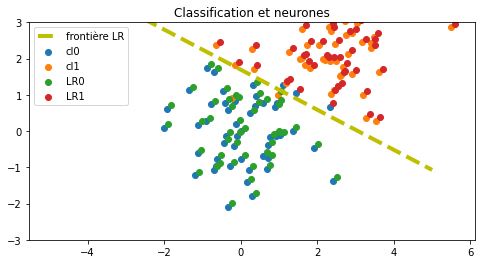

In [27]:
h = 0.1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
ax.scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
ax.scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
ax.scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax.set_ylim([-3, 3])
ax.legend()
ax.set_title("Classification et neurones");

Un neurone de classification binaire produit deux sorties, une pour chaque classe, et sont normalisées à 1. La fonction d'activation est la fonction [softmax](https://en.wikipedia.org/wiki/Softmax_function).

In [28]:
clsY = numpy.empty((clsy.shape[0], 2), dtype=numpy.float64)
clsY[:, 1] = clsy
clsY[:, 0] = 1 - clsy

In [29]:
softneu = NeuralTreeNode(2, activation='softmax')
softneu

NeuralTreeNode(weights=array([[-2.08861923,  0.18763489],
       [ 0.35500659, -0.39231456]]), bias=array([-0.03589328,  0.383808  ]), activation='softmax')

In [30]:
softneu.fit(clsX, clsY, verbose=True, max_iter=20, lr=0.001)

0/20: loss: 510.6 lr=0.001 max(coef): 2.1 l1=0/3.4 l2=0/4.8
1/20: loss: 297.8 lr=9.95e-05 max(coef): 4.5 l1=37/18 l2=2.5e+02/67
2/20: loss: 291.4 lr=7.05e-05 max(coef): 5.2 l1=9.7/21 l2=20/89
3/20: loss: 280.7 lr=5.76e-05 max(coef): 5.4 l1=30/23 l2=1.8e+02/98
4/20: loss: 273.4 lr=4.99e-05 max(coef): 5.7 l1=15/23 l2=99/1.1e+02
5/20: loss: 265.4 lr=4.47e-05 max(coef): 5.9 l1=19/24 l2=1e+02/1.1e+02
6/20: loss: 260.8 lr=4.08e-05 max(coef): 6.1 l1=26/25 l2=1.6e+02/1.2e+02
7/20: loss: 257.8 lr=3.78e-05 max(coef): 6.3 l1=28/26 l2=1.6e+02/1.3e+02
8/20: loss: 251.5 lr=3.53e-05 max(coef): 6.5 l1=35/26 l2=2.3e+02/1.3e+02
9/20: loss: 247.8 lr=3.33e-05 max(coef): 6.6 l1=33/27 l2=2.3e+02/1.4e+02
10/20: loss: 244.6 lr=3.16e-05 max(coef): 6.8 l1=36/27 l2=2.6e+02/1.4e+02
11/20: loss: 241.2 lr=3.01e-05 max(coef): 6.9 l1=43/28 l2=3.4e+02/1.5e+02
12/20: loss: 236.9 lr=2.89e-05 max(coef): 7 l1=31/28 l2=2e+02/1.5e+02
13/20: loss: 233.2 lr=2.77e-05 max(coef): 7.2 l1=18/29 l2=1.2e+02/1.6e+02
14/20: loss: 232.

NeuralTreeNode(weights=array([[2.39484139, 4.03623835],
       [5.41545461, 7.01868202]]), bias=array([7.94607355, 4.95768881]), activation='softmax')

In [31]:
pred = softneu.predict(clsX)
pred[:5]

array([[9.89410479e-01, 1.05895211e-02],
       [9.96986932e-02, 9.00301307e-01],
       [9.97104404e-01, 2.89559597e-03],
       [9.99839780e-01, 1.60220367e-04],
       [9.62522709e-01, 3.74772912e-02]])

In [32]:
pred2 = (pred[:, 1] > 0.5).astype(numpy.int64)

In [33]:
x00, y00, x01, y01 = line_cls(-4, 4, softneu.coef[:1, 1:], softneu.bias[0])
x10, y10, x11, y11 = line_cls(-4, 4, softneu.coef[1:, 1:], softneu.bias[1])
xa, ya, xb, yb = line_cls(
    -5, 5, softneu.coef[1:, 1:] - softneu.coef[:1, 1:],
    softneu.bias[1] - softneu.bias[0])

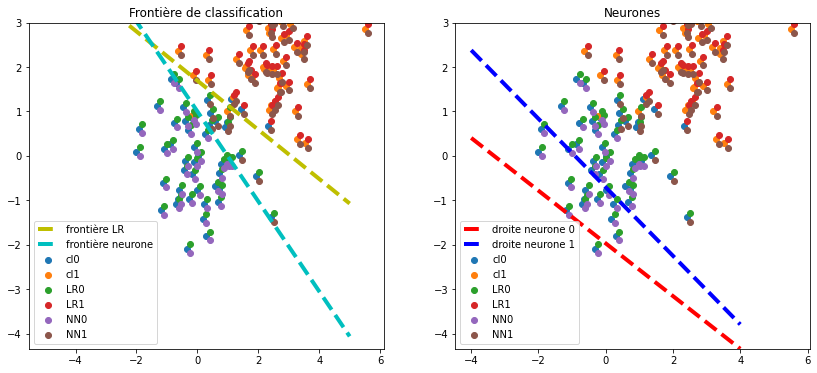

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i in [0, 1]:
    ax[i].scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
    ax[i].scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
    ax[i].scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
    ax[i].scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
    ax[i].scatter(clsX[pred2 == 0, 0] + h, clsX[pred2 == 0, 1] - h, label='NN0')
    ax[i].scatter(clsX[pred2 == 1, 0] + h, clsX[pred2 == 1, 1] - h, label='NN1')
ax[0].plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax[1].plot([x00, x01], [y00, y01], 'r--', lw=4, label='droite neurone 0')
ax[1].plot([x10, x11], [y10, y11], 'b--', lw=4, label='droite neurone 1')
ax[0].plot([xa, xb], [ya, yb], 'c--', lw=4, label='frontière neurone')
ax[0].set_ylim([max(-6, min([-3, y10, y11, y11, y01])),
                min(6, max([3, y10, y11, y11, y01]))])
ax[1].set_ylim([max(-6, min([-3, y10, y11, y11, y01])),
                min(6, max([3, y10, y11, y11, y01]))])
ax[0].legend()
ax[1].legend()
ax[0].set_title("Frontière de classification")
ax[1].set_title("Neurones");

Ca marche. On vérifie en calculant le score. Le neurone a deux sorties. La frontière est définie par l'ensemble des points pour lesquels les deux sorties sont égales. Par conséquent, la distance entre les deux droites définies par les coefficients du neurone doivent être égales. Il existe une infinité de solutions menant à la même frontière. On pourrait pénaliser les coefficients pour converger toujours vers la même solution.

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(clsy, logr.predict_proba(clsX)[:, 1])

0.9924

In [36]:
roc_auc_score(clsy, softneu.predict(clsX)[:, 1])

0.986

La performance est quasiment identique. Que ce soit la régression ou la classification, l'apprentissage d'un neurone fonctionne. En sera-t-il de même pour un assemblage de neurones ?

## Apprentissage du réseau de neurones

Maintenant qu'on a vu les différentes fonctions d'activations et leur application sur des problèmes simples, on revient aux arbres convertis sous la forme d'un réseau de neurones. La prochaine étape est de pouvoir améliorer les performances du modèle issu de la conversion d'un arbre de classification avec un algorithme du gradient. On construit pour cela un nuage de points un peu traficoté.

In [37]:
clsX = numpy.empty((150, 2), dtype=numpy.float64)
clsX[:100] = numpy.random.randn(100, 2)
clsX[:20, 0] -= 1
clsX[20:40, 0] -= 0.8
clsX[:100, 1] /= 2
clsX[:100, 1] += clsX[:100, 0] ** 2
clsX[100:] = numpy.random.randn(50, 2)
clsX[100:, 0] /= 2
clsX[100:, 1] += 2.5
clsy = numpy.zeros(X.shape[0], dtype=numpy.int64)
clsy[100:] = 1

logr = LogisticRegression()
logr.fit(clsX, clsy)
pred1 = logr.predict(clsX)
logr.score(clsX, clsy)

0.68

In [38]:
x0, y0, x1, y1 = line_cls(-3, 3, logr.coef_, logr.intercept_)

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


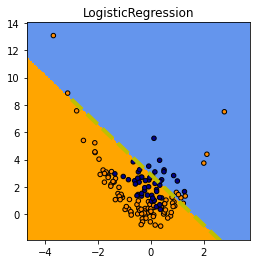

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_grid(clsX, clsy, logr.predict, logr.__class__.__name__, ax=ax)
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR');

Même chose avec un arbre de décision et le réseau de neurones converti.

In [40]:
dec = DecisionTreeClassifier(max_depth=2)
dec.fit(clsX, clsy)
pred2 = dec.predict(clsX)
dec.score(clsX, clsy)

0.9066666666666666

On convertit de réseau de neurones. Le second argument définit la pente dans la fonction d'activation.

In [41]:
net = NeuralTreeNet.create_from_tree(dec, 0.5)
net15 = NeuralTreeNet.create_from_tree(dec, 15)

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
(roc_auc_score(clsy, dec.predict_proba(clsX)[:, 1]),
 accuracy_score(clsy, dec.predict(clsX)))

(0.9354999999999999, 0.9066666666666666)

In [44]:
(roc_auc_score(clsy, net.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(net.predict(clsX)[:, -2:], axis=1)))

(0.9456, 0.8333333333333334)

In [45]:
(roc_auc_score(clsy, net15.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(net15.predict(clsX)[:, -2:], axis=1)))

(0.9071, 0.9)

Le réseau de neurones est plus ou moins performant selon la pente dans la fonction d'activation.

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


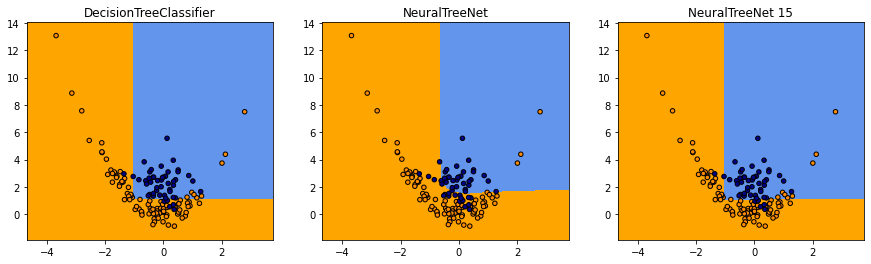

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plot_grid(clsX, clsy, dec.predict, dec.__class__.__name__, ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          net.__class__.__name__, ax=ax[1])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net15.predict(x)[:, -2:], axis=1),
          net15.__class__.__name__ + ' 15', ax=ax[2])

Et on apprend le réseau de neurones en partant de l'arbre de départ. On choisit celui qui a la pente d'activation la plus faible.

In [47]:
from mlstatpy.ml.neural_tree import label_class_to_softmax_output
clsY = label_class_to_softmax_output(clsy)
clsY[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]])

In [48]:
net2 = net.copy()
net2.fit(clsX, clsY, verbose=True, max_iter=25, lr=3e-6)

0/25: loss: 728.3 lr=3e-06 max(coef): 1 l1=0/14 l2=0/9.5
1/25: loss: 706.4 lr=2.44e-07 max(coef): 1 l1=2.4e+02/14 l2=3.3e+03/9.3
2/25: loss: 704.8 lr=1.73e-07 max(coef): 1 l1=2.4e+02/14 l2=3.3e+03/9.3
3/25: loss: 704.6 lr=1.41e-07 max(coef): 1 l1=2.9e+02/14 l2=4e+03/9.3
4/25: loss: 703.8 lr=1.22e-07 max(coef): 1 l1=4.4e+02/14 l2=1.4e+04/9.3
5/25: loss: 703.5 lr=1.09e-07 max(coef): 1.1 l1=2.5e+02/14 l2=3.5e+03/9.3
6/25: loss: 703.2 lr=9.99e-08 max(coef): 1.1 l1=1.8e+02/14 l2=3.2e+03/9.3
7/25: loss: 703 lr=9.25e-08 max(coef): 1.1 l1=2e+02/14 l2=2.7e+03/9.3
8/25: loss: 702.9 lr=8.66e-08 max(coef): 1.1 l1=3e+02/14 l2=4.1e+03/9.3
9/25: loss: 702.9 lr=8.16e-08 max(coef): 1.1 l1=1.9e+02/14 l2=2.9e+03/9.3
10/25: loss: 702.8 lr=7.74e-08 max(coef): 1.1 l1=3e+02/14 l2=4e+03/9.3
11/25: loss: 702.7 lr=7.38e-08 max(coef): 1.1 l1=2.7e+02/14 l2=4.1e+03/9.3
12/25: loss: 702.7 lr=7.07e-08 max(coef): 1.1 l1=2.5e+02/14 l2=3.5e+03/9.3
13/25: loss: 702.5 lr=6.79e-08 max(coef): 1.1 l1=1.9e+02/14 l2=3.2e+03/9

NeuralTreeNet(2)

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


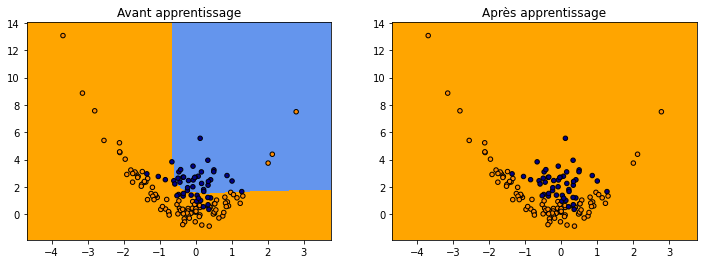

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          "Avant apprentissage", ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net2.predict(x)[:, -2:], axis=1),
          "Après apprentissage", ax=ax[1])

Ca ne marche pas ou pas très bien. Il faudrait vérifier que la configuration actuelle ne se trouve pas dans un minimum local auquel cas l'apprentissage par gradient ne donnera quasiment rien.

In [50]:
(roc_auc_score(clsy, net2.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(net2.predict(clsX)[:, -2:], axis=1)))

(0.9394, 0.6666666666666666)

In [51]:
net2.predict(clsX)[-5:, -2:]

array([[0.59760975, 0.40239025],
       [0.69897705, 0.30102295],
       [0.616117  , 0.383883  ],
       [0.66792189, 0.33207811],
       [0.78813475, 0.21186525]])

In [52]:
net.predict(clsX)[-5:, -2:]

array([[0.48111758, 0.51888242],
       [0.58040964, 0.41959036],
       [0.50511128, 0.49488872],
       [0.54010078, 0.45989922],
       [0.69670643, 0.30329357]])

On peut essayer de repartir à zéro. Des fois ça peut marcher mais il faudrait beaucoup plus d'essai.

In [53]:
net3 = net.copy()
dim = net3.training_weights.shape
net3.update_training_weights(numpy.random.randn(dim[0]))
net3.fit(clsX, clsY, verbose=True, max_iter=25, lr=3e-6)

0/25: loss: 796.4 lr=3e-06 max(coef): 2.6 l1=0/29 l2=0/43
1/25: loss: 796.4 lr=2.44e-07 max(coef): 2.5 l1=5.6e+02/29 l2=1.5e+04/42
2/25: loss: 796.4 lr=1.73e-07 max(coef): 2.6 l1=5e+02/29 l2=1.4e+04/42
3/25: loss: 796.5 lr=1.41e-07 max(coef): 2.6 l1=5.8e+02/29 l2=1.6e+04/42
4/25: loss: 796.5 lr=1.22e-07 max(coef): 2.6 l1=7.6e+02/29 l2=2.5e+04/42
5/25: loss: 796.5 lr=1.09e-07 max(coef): 2.6 l1=5.1e+02/29 l2=1.4e+04/42
6/25: loss: 796.6 lr=9.99e-08 max(coef): 2.6 l1=6.2e+02/29 l2=1.9e+04/42
7/25: loss: 796.6 lr=9.25e-08 max(coef): 2.6 l1=6.2e+02/29 l2=1.9e+04/42
8/25: loss: 796.6 lr=8.66e-08 max(coef): 2.6 l1=6e+02/29 l2=1.7e+04/42
9/25: loss: 796.6 lr=8.16e-08 max(coef): 2.6 l1=5.9e+02/29 l2=1.6e+04/42
10/25: loss: 796.6 lr=7.74e-08 max(coef): 2.6 l1=5.6e+02/29 l2=1.5e+04/42
11/25: loss: 796.6 lr=7.38e-08 max(coef): 2.6 l1=7.3e+02/29 l2=2.3e+04/42
12/25: loss: 796.6 lr=7.07e-08 max(coef): 2.6 l1=7.4e+02/30 l2=2.4e+04/42
13/25: loss: 796.6 lr=6.79e-08 max(coef): 2.6 l1=6.8e+02/30 l2=2.1e

NeuralTreeNet(2)

In [54]:
(roc_auc_score(clsy, net3.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(net3.predict(clsX)[:, -2:], axis=1)))

(0.6426000000000001, 0.6666666666666666)

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


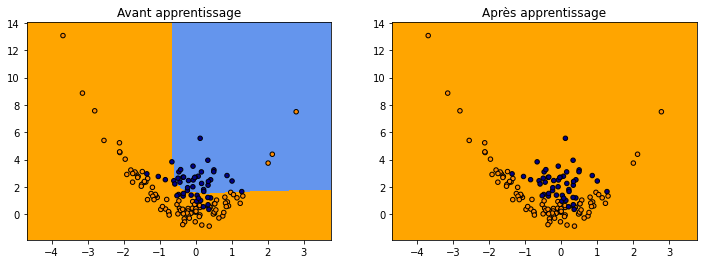

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          "Avant apprentissage", ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net3.predict(x)[:, -2:], axis=1),
          "Après apprentissage", ax=ax[1])

## Autre architecture

Cette fois-ci, on réduit le nombre de neurones. Au lieu d'avoir deux neurones par noeud du graphe, on assemble tous les neurones en deux : un pour les entrées, un autre pour le calcul des sorties.

In [56]:
netc = NeuralTreeNet.create_from_tree(dec, 1, arch='compact')
RenderJsDot(netc.to_dot())

In [57]:
(roc_auc_score(clsy, netc.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(netc.predict(clsX)[:, -2:], axis=1)))

(0.9468, 0.62)

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


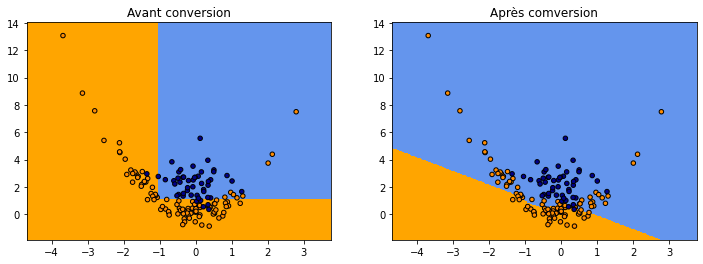

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(dec.predict_proba(x), axis=1),
          "Avant conversion", ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(netc.predict(x)[:, -2:], axis=1),
          "Après comversion", ax=ax[1])

On réapprend.

In [59]:
netc4 = netc.copy()
netc4.fit(clsX, clsY, verbose=True, max_iter=25, lr=1e-6)

0/25: loss: 791.1 lr=1e-06 max(coef): 1.1 l1=0/25 l2=0/25
1/25: loss: 482.9 lr=8.14e-08 max(coef): 1.1 l1=3.1e+02/25 l2=4.9e+03/25
2/25: loss: 459 lr=5.76e-08 max(coef): 1.1 l1=2.7e+02/25 l2=4.3e+03/25
3/25: loss: 452.9 lr=4.71e-08 max(coef): 1.1 l1=9e+02/25 l2=5.8e+04/25
4/25: loss: 447.6 lr=4.08e-08 max(coef): 1.1 l1=5.4e+02/25 l2=1.7e+04/25
5/25: loss: 442.9 lr=3.65e-08 max(coef): 1.1 l1=8.2e+02/25 l2=4.5e+04/25
6/25: loss: 439.6 lr=3.33e-08 max(coef): 1.1 l1=3.9e+02/25 l2=6.1e+03/25
7/25: loss: 436.4 lr=3.08e-08 max(coef): 1.1 l1=3.8e+02/25 l2=6.2e+03/25
8/25: loss: 433.2 lr=2.89e-08 max(coef): 1.1 l1=8.6e+02/25 l2=5.3e+04/25
9/25: loss: 429.5 lr=2.72e-08 max(coef): 1.1 l1=3.2e+02/25 l2=5.5e+03/25
10/25: loss: 426.9 lr=2.58e-08 max(coef): 1.1 l1=7.6e+02/25 l2=3.5e+04/25
11/25: loss: 424.2 lr=2.46e-08 max(coef): 1.1 l1=3.7e+02/25 l2=6.4e+03/25
12/25: loss: 421.9 lr=2.36e-08 max(coef): 1.1 l1=8e+02/25 l2=4.2e+04/25
13/25: loss: 420.5 lr=2.26e-08 max(coef): 1.1 l1=4.3e+02/25 l2=8.6e+0

NeuralTreeNet(2)

In [60]:
(roc_auc_score(clsy, netc4.predict(clsX)[:, -1]),
 accuracy_score(clsy, numpy.argmax(netc4.predict(clsX)[:, -2:], axis=1)))

(0.9338000000000001, 0.8866666666666667)

<ipython-input-23-56151b64b872>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


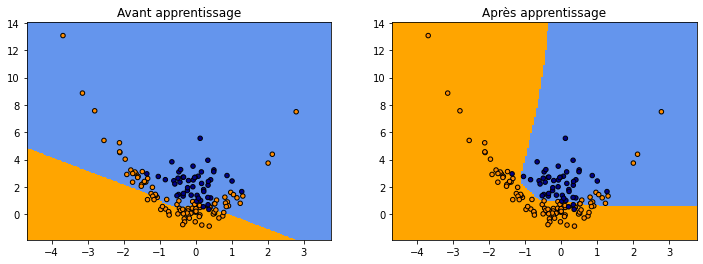

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(netc.predict(x)[:, -2:], axis=1),
          "Avant apprentissage", ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(netc4.predict(x)[:, -2:], axis=1),
          "Après apprentissage", ax=ax[1])

C'est mieux...